In [1]:
import pandas as pd
import folium
import geopandas as gpd
import zipfile
import requests
from io import BytesIO
import seaborn as sns

# Setup inicial

In [2]:
url_2010 = 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/SP_Capital_20231030.zip'
url_2022 = 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/agregados_por_setores_csv/UF/Agregados_preliminares_por_setores_censitarios_SP.csv'

sns.set_style("whitegrid")

## Censo 2010

Como a divulgação do Censo de 2010 foi em um arquivo zip com múltiplos arquivos, precisamos extrair o questionário a ser aberto primeiro. Além disso, a variável de distrito e de população total estão em arquivos diferentes, portanto precisaremos baixar os dois arquivos e unificá-los.

Além disso, o arquivo `Domicilio02_SP1.csv` possui um erro na coluna `Cod_setor`, com todas as linhas apresentando o valor `3,55031E+14`. Por isso, o arquivo `Domicilio02_SP1.xls` será utilizado em seu lugar.

In [3]:
r = requests.get(url_2010)

with zipfile.ZipFile(BytesIO(r.content)) as z:
   with z.open('Base informaçoes setores2010 universo SP_Capital/EXCEL/Domicilio02_SP1.xls') as f:
      censo10_dom = pd.read_excel(f, thousands='.', decimal=',')

censo10_dom.head()

,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132
0,355030801000001,1,806,800,623,66,28,399,27,360,...,1,0,0,425,425,0,0,415,10,0
1,355030801000002,1,913,913,891,22,0,567,36,261,...,0,0,0,495,495,0,0,421,74,0
2,355030801000003,1,625,625,595,4,18,462,5,151,...,0,0,0,329,318,11,0,309,9,0
3,355030801000004,1,572,572,496,11,65,229,8,286,...,0,0,0,296,296,0,0,274,12,10
4,355030801000005,1,754,754,716,3,30,340,15,354,...,0,0,0,399,399,0,0,162,210,27


In [4]:
r = requests.get(url_2010)

with zipfile.ZipFile(BytesIO(r.content)) as z:
   with z.open('Base informaçoes setores2010 universo SP_Capital/CSV/Basico_SP1.csv') as f:
      censo10_bas = pd.read_csv(f, encoding='latin1', sep=';', thousands='.', decimal=',')

censo10_bas.head()

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V004,V005,V006,V007,V008,V009,V010,V011,V012,Unnamed: 32
0,355030801000001,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86,NaN
1,355030801000002,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94,NaN
2,355030801000003,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74,NaN
3,355030801000004,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24,NaN
4,355030801000005,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85,NaN


Finalmente, a variável de interesse é a `V001` do arquivo `Domicilio02_SP1.xls`, então precisaremos apenas desta variável e das informações básicas do setor do arquivo `Basico_SP1.csv`.

In [5]:
censo10_bas.columns

Index(['Cod_setor', 'Cod_Grandes Regiões', 'Nome_Grande_Regiao', 'Cod_UF',
       'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro',
       'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio',
       'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito',
       'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro', 'Situacao_setor',
       'V001', 'V002', 'V003', 'V004', 'V005', 'V006', 'V007', 'V008', 'V009',
       'V010', 'V011', 'V012', 'Unnamed: 32'],
      dtype='object')

In [6]:
censo10 = censo10_bas[['Cod_setor', 'Cod_Grandes Regiões', 'Nome_Grande_Regiao', 'Cod_UF',
       'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro',
       'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio',
       'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito',
       'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro', 'Situacao_setor']]
censo10 = censo10.merge(censo10_dom[['Cod_setor','V001']], how='left')
censo10.head()

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,V001
0,355030801000001,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3550308,SÃO PAULO,355030801,ÁGUA RASA,35503080100,ÁGUA RASA,3550308000,SÃO PAULO (todos os setores),1,806
1,355030801000002,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3550308,SÃO PAULO,355030801,ÁGUA RASA,35503080100,ÁGUA RASA,3550308000,SÃO PAULO (todos os setores),1,913
2,355030801000003,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3550308,SÃO PAULO,355030801,ÁGUA RASA,35503080100,ÁGUA RASA,3550308000,SÃO PAULO (todos os setores),1,625
3,355030801000004,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3550308,SÃO PAULO,355030801,ÁGUA RASA,35503080100,ÁGUA RASA,3550308000,SÃO PAULO (todos os setores),1,572
4,355030801000005,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,3550308,SÃO PAULO,355030801,ÁGUA RASA,35503080100,ÁGUA RASA,3550308000,SÃO PAULO (todos os setores),1,754


## Censo de 2022

In [7]:
censo22 = pd.read_csv(url_2022, sep=';')
censo22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,NM_RGINT,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007
0,350010505000001P,0.123823,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,...,Presidente Prudente,NaN,NaN,288,199,199,0,2.086957,16.666667,138
1,350010505000002P,0.202614,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,...,Presidente Prudente,NaN,NaN,674,339,339,0,2.407143,1.428571,280
2,350010505000003P,0.235051,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,...,Presidente Prudente,NaN,NaN,380,269,268,1,1.914141,4.040404,198
3,350010505000004P,0.288466,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,...,Presidente Prudente,NaN,NaN,570,290,288,2,2.398305,1.271186,236
4,350010505000005P,0.213725,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,...,Presidente Prudente,NaN,NaN,612,313,312,1,2.220588,4.044118,272


Como o censo 2022 possui todos os municípios de SP, precisamos filtrar apenas São Paulo

In [8]:
censo22 = censo22.query('CD_MUN == 3550308')
censo22.head()

,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,NM_RGINT,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007
65763,355030801000001P,0.071797,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo,3550308.0,São Paulo/SP,682,329,329,0,2.359862,3.806228,289
65764,355030801000002P,0.071902,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo,3550308.0,São Paulo/SP,1374,1011,1011,0,2.293823,1.502504,599
65765,355030801000003P,0.055681,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo,3550308.0,São Paulo/SP,557,239,238,1,2.673171,9.268293,205
65766,355030801000004P,0.064905,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo,3550308.0,São Paulo/SP,526,245,245,0,2.380090,1.357466,221
65767,355030801000005P,0.086820,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,...,São Paulo,3550308.0,São Paulo/SP,579,258,258,0,2.619910,9.049774,221


# Checagem dos distritos

Agora checo os códigos dos distritos para garantir que são os mesmos

In [9]:
censo10.columns

Index(['Cod_setor', 'Cod_Grandes Regiões', 'Nome_Grande_Regiao', 'Cod_UF',
       'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro',
       'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio',
       'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito',
       'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro', 'Situacao_setor',
       'V001'],
      dtype='object')

In [10]:
dist10 = censo10[['Cod_distrito', 'Nome_do_distrito']].drop_duplicates()

In [11]:
dist22 = censo22[['CD_DIST', 'NM_DIST']].drop_duplicates()

In [12]:
dist_join = dist10.merge(dist22, how='left', left_on='Cod_distrito', right_on='CD_DIST')
dist_join

,Cod_distrito,Nome_do_distrito,CD_DIST,NM_DIST
0,355030801,ÁGUA RASA,355030801,Água Rasa
1,355030802,ALTO DE PINHEIROS,355030802,Alto de Pinheiros
2,355030803,ANHANGUERA,355030803,Anhanguera
3,355030804,ARICANDUVA,355030804,Aricanduva
4,355030805,ARTUR ALVIM,355030805,Artur Alvim
...,...,...,...,...
91,355030892,VILA MEDEIROS,355030892,Vila Medeiros
92,355030893,VILA PRUDENTE,355030893,Vila Prudente
93,355030894,VILA SÔNIA,355030894,Vila Sônia
94,355030895,SÃO DOMINGOS,355030895,São Domingos


In [13]:
dist_join['nomes_iguais'] = dist_join['Nome_do_distrito'].str.lower() == dist_join['NM_DIST'].str.lower()

In [14]:
dist_join['nomes_iguais'].value_counts()

nomes_iguais
True    96
Name: count, dtype: int64

Todos os códigos dos distritos possuem correspondência e os nomes permanecem o mesmo em todos os casos. De agora em diante assumo que os distritos são os mesmos entre os dois censos

# Agregando os dados por distrito

In [15]:
censo10_dist = censo10[['Cod_distrito', 'V001']].groupby('Cod_distrito').sum().reset_index()
censo10_dist = censo10_dist.rename(columns={'V001': 'pop_total_2010'})
censo10_dist

,Cod_distrito,pop_total_2010
0,355030801,84963
1,355030802,43117
2,355030803,65859
3,355030804,89622
4,355030805,105269
...,...,...
91,355030892,129919
92,355030893,104242
93,355030894,108441
94,355030895,84843


In [16]:
censo22_dist = censo22[['CD_DIST', 'v0001']].groupby('CD_DIST').sum().reset_index()
censo22_dist = censo22_dist.rename(columns={'CD_DIST': 'Cod_distrito', 'v0001': 'pop_total_2022'})
censo22_dist

,Cod_distrito,pop_total_2022
0,355030801,85788
1,355030802,37359
2,355030803,75360
3,355030804,89574
4,355030805,95575
...,...,...
91,355030892,114939
92,355030893,105690
93,355030894,123748
94,355030895,88884


In [17]:
censo_pop = censo10_dist.merge(censo22_dist)
censo_pop

,Cod_distrito,pop_total_2010,pop_total_2022
0,355030801,84963,85788
1,355030802,43117,37359
2,355030803,65859,75360
3,355030804,89622,89574
4,355030805,105269,95575
...,...,...,...
91,355030892,129919,114939
92,355030893,104242,105690
93,355030894,108441,123748
94,355030895,84843,88884


In [18]:
censo_pop['var_pop'] = censo_pop['pop_total_2022'] - censo_pop['pop_total_2010']
censo_pop

,Cod_distrito,pop_total_2010,pop_total_2022,var_pop
0,355030801,84963,85788,825
1,355030802,43117,37359,-5758
2,355030803,65859,75360,9501
3,355030804,89622,89574,-48
4,355030805,105269,95575,-9694
...,...,...,...,...
91,355030892,129919,114939,-14980
92,355030893,104242,105690,1448
93,355030894,108441,123748,15307
94,355030895,84843,88884,4041


In [19]:
censo_pop['var_perc_pop'] = censo_pop['var_pop']/censo_pop['pop_total_2010']
censo_pop

,Cod_distrito,pop_total_2010,pop_total_2022,var_pop,var_perc_pop
0,355030801,84963,85788,825,0.009710
1,355030802,43117,37359,-5758,-0.133544
2,355030803,65859,75360,9501,0.144263
3,355030804,89622,89574,-48,-0.000536
4,355030805,105269,95575,-9694,-0.092088
...,...,...,...,...,...
91,355030892,129919,114939,-14980,-0.115303
92,355030893,104242,105690,1448,0.013891
93,355030894,108441,123748,15307,0.141155
94,355030895,84843,88884,4041,0.047629


# Agregando dados geoespaciais

In [20]:
url = "https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/malha_com_atributos/distritos/json/UF/SP/SP_Malha_Preliminar_Distrito_2022.zip"
distritos_geo = gpd.read_file(url)

In [21]:
distritos_geo

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
0,3,Sudeste,35,São Paulo,3500105,Adamantina,350010505,Adamantina,107,34687,15966,15945,21,2.543721,2.186074,13586,"POLYGON ((-51.09557 -21.57029, -51.09536 -21.5..."
1,3,Sudeste,35,São Paulo,3500204,Adolfo,350020405,Adolfo,16,4351,2469,2468,1,2.636970,2.484848,1650,"POLYGON ((-49.61249 -21.26110, -49.61234 -21.2..."
2,3,Sudeste,35,São Paulo,3500303,Aguaí,350030305,Aguaí,63,32072,13586,13579,7,2.788034,1.898459,11483,"POLYGON ((-47.01254 -22.00527, -47.01277 -22.0..."
3,3,Sudeste,35,São Paulo,3500402,Águas da Prata,350040205,Águas da Prata,18,5739,3165,3161,4,2.516287,1.338688,2241,"POLYGON ((-46.71875 -21.95837, -46.71852 -21.9..."
4,3,Sudeste,35,São Paulo,3500402,Águas da Prata,350040210,São Roque da Fartura,6,1630,748,747,1,2.758037,1.015228,591,"POLYGON ((-46.73337 -21.87262, -46.73196 -21.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,3,Sudeste,35,São Paulo,3557105,Votuporanga,355710515,Simonsen,2,1222,652,652,0,2.645022,0.649351,462,"POLYGON ((-49.85227 -20.41665, -49.85273 -20.4..."
1035,3,Sudeste,35,São Paulo,3557154,Zacarias,355715405,Zacarias,19,2692,1617,1617,0,2.549242,0.284091,1056,"POLYGON ((-49.98507 -21.05306, -49.98477 -21.0..."
1036,3,Sudeste,35,São Paulo,3557204,Chavantes,355720405,Chavantes,29,10353,4441,4437,4,2.763997,1.419770,3733,"POLYGON ((-49.73594 -23.03489, -49.72426 -23.0..."
1037,3,Sudeste,35,São Paulo,3557204,Chavantes,355720415,Irapé,8,1858,758,757,1,3.021207,0.489396,613,"POLYGON ((-49.73594 -23.03489, -49.74234 -23.0..."


In [22]:
distritos_geo['CD_DIST'] = distritos_geo['CD_DIST'].astype(str)
censo_pop['Cod_distrito'] = censo_pop['Cod_distrito'].astype(str)

Os polígonos dos distritos vieram também com os dados já obtidos pelo `csv`. Vamos filtrar apenas as colunas de interesse para o futuro merge.

In [23]:
distritos_geo.columns

Index(['CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF', 'CD_MUN', 'NM_MUN',
       'CD_DIST', 'NM_DIST', 'T_SETORES', 'v0001', 'v0002', 'v0003', 'v0004',
       'v0005', 'v0006', 'v0007', 'geometry'],
      dtype='object')

In [24]:
distritos_geo = distritos_geo[['CD_DIST', 'NM_DIST', 'geometry']]
distritos_geo

,CD_DIST,NM_DIST,geometry
0,350010505,Adamantina,"POLYGON ((-51.09557 -21.57029, -51.09536 -21.5..."
1,350020405,Adolfo,"POLYGON ((-49.61249 -21.26110, -49.61234 -21.2..."
2,350030305,Aguaí,"POLYGON ((-47.01254 -22.00527, -47.01277 -22.0..."
3,350040205,Águas da Prata,"POLYGON ((-46.71875 -21.95837, -46.71852 -21.9..."
4,350040210,São Roque da Fartura,"POLYGON ((-46.73337 -21.87262, -46.73196 -21.8..."
...,...,...,...
1034,355710515,Simonsen,"POLYGON ((-49.85227 -20.41665, -49.85273 -20.4..."
1035,355715405,Zacarias,"POLYGON ((-49.98507 -21.05306, -49.98477 -21.0..."
1036,355720405,Chavantes,"POLYGON ((-49.73594 -23.03489, -49.72426 -23.0..."
1037,355720415,Irapé,"POLYGON ((-49.73594 -23.03489, -49.74234 -23.0..."


Esse dataframe também possui dados de fora do município de São Paulo. Como nosso interesse é apenas no município de São Paulo, o merge utilizará inner join para manter apenas os distritos presentes no nosso dataframe não georreferenciado.

In [25]:
df_final = distritos_geo.merge(censo_pop, how='inner', left_on='CD_DIST', right_on='Cod_distrito')
df_final

,CD_DIST,NM_DIST,geometry,Cod_distrito,pop_total_2010,pop_total_2022,var_pop,var_perc_pop
0,355030801,Água Rasa,"POLYGON ((-46.57207 -23.57948, -46.57199 -23.5...",355030801,84963,85788,825,0.009710
1,355030802,Alto de Pinheiros,"POLYGON ((-46.69581 -23.55327, -46.69576 -23.5...",355030802,43117,37359,-5758,-0.133544
2,355030803,Anhanguera,"POLYGON ((-46.76157 -23.43178, -46.76158 -23.4...",355030803,65859,75360,9501,0.144263
3,355030804,Aricanduva,"POLYGON ((-46.51779 -23.58627, -46.51736 -23.5...",355030804,89622,89574,-48,-0.000536
4,355030805,Artur Alvim,"POLYGON ((-46.48574 -23.55441, -46.48526 -23.5...",355030805,105269,95575,-9694,-0.092088
...,...,...,...,...,...,...,...,...
91,355030892,Vila Medeiros,"POLYGON ((-46.57783 -23.49527, -46.57749 -23.4...",355030892,129919,114939,-14980,-0.115303
92,355030893,Vila Prudente,"POLYGON ((-46.57480 -23.60107, -46.57429 -23.6...",355030893,104242,105690,1448,0.013891
93,355030894,Vila Sônia,"POLYGON ((-46.72791 -23.61149, -46.72780 -23.6...",355030894,108441,123748,15307,0.141155
94,355030895,São Domingos,"POLYGON ((-46.74670 -23.50750, -46.74428 -23.5...",355030895,84843,88884,4041,0.047629


In [26]:
df_final['Variação populacional'] = df_final['var_perc_pop'].apply(lambda x: '{:.2%}'.format(x) if x < 0 else '+{:.2%}'.format(x))
df_final

,CD_DIST,NM_DIST,geometry,Cod_distrito,pop_total_2010,pop_total_2022,var_pop,var_perc_pop,Variação populacional
0,355030801,Água Rasa,"POLYGON ((-46.57207 -23.57948, -46.57199 -23.5...",355030801,84963,85788,825,0.009710,+0.97%
1,355030802,Alto de Pinheiros,"POLYGON ((-46.69581 -23.55327, -46.69576 -23.5...",355030802,43117,37359,-5758,-0.133544,-13.35%
2,355030803,Anhanguera,"POLYGON ((-46.76157 -23.43178, -46.76158 -23.4...",355030803,65859,75360,9501,0.144263,+14.43%
3,355030804,Aricanduva,"POLYGON ((-46.51779 -23.58627, -46.51736 -23.5...",355030804,89622,89574,-48,-0.000536,-0.05%
4,355030805,Artur Alvim,"POLYGON ((-46.48574 -23.55441, -46.48526 -23.5...",355030805,105269,95575,-9694,-0.092088,-9.21%
...,...,...,...,...,...,...,...,...,...
91,355030892,Vila Medeiros,"POLYGON ((-46.57783 -23.49527, -46.57749 -23.4...",355030892,129919,114939,-14980,-0.115303,-11.53%
92,355030893,Vila Prudente,"POLYGON ((-46.57480 -23.60107, -46.57429 -23.6...",355030893,104242,105690,1448,0.013891,+1.39%
93,355030894,Vila Sônia,"POLYGON ((-46.72791 -23.61149, -46.72780 -23.6...",355030894,108441,123748,15307,0.141155,+14.12%
94,355030895,São Domingos,"POLYGON ((-46.74670 -23.50750, -46.74428 -23.5...",355030895,84843,88884,4041,0.047629,+4.76%


# Avaliando a mudança populacional

Antes de avaliarmos no mapa, vale uma avaliação da distribuição estatística da variação populacional

In [27]:
df_final['var_perc_pop'].describe()

count    96.000000
mean      0.041789
std       0.166601
min      -0.135848
25%      -0.041975
50%       0.005293
75%       0.082527
max       1.324689
Name: var_perc_pop, dtype: float64

Vemos que a média é de aumento populacional, mas abaixo do crescimento nacional (de 6,5%, como aponta [essa reportagem](https://www.cnnbrasil.com.br/nacional/censo-2022-taxa-de-crescimento-anual-da-populacao-do-brasil-bate-052-a-menor-da-historia/)). Além disso, a média acima da mediana e a comparação entre o Q3 e o valor máximo indica a presença de outliers na cauda direita da distribuição. Vamos avaliar essa hipótese com um boxplot.

<Axes: >

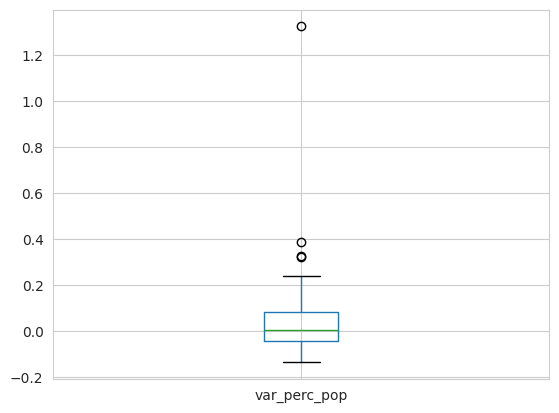

In [28]:
df_final.boxplot('var_perc_pop', return_type='axes')

Como era esperado, o boxplot exibe alguns outliers do lado positivo da distribuição. Vamos exibir quais são esses distritos.

In [31]:
B = df_final.boxplot('var_perc_pop', return_type='dict')
whiskers = [item.get_ydata()[1] for item in B['whiskers']]
whiskers

[-0.13584797005470775, 0.2380984086823357]

In [32]:
df_final.query(f'var_perc_pop > {whiskers[1]}').sort_values('var_perc_pop', ascending=False)

,CD_DIST,NM_DIST,geometry,Cod_distrito,pop_total_2010,pop_total_2022,var_pop,var_perc_pop,Variação populacional
5,355030806,Barra Funda,"POLYGON ((-46.67363 -23.53182, -46.67356 -23.5...",355030806,14383,33436,19053,1.324689,+132.47%
51,355030852,Marsilac,"POLYGON ((-46.71565 -23.88130, -46.71728 -23.8...",355030852,8258,11443,3185,0.385687,+38.57%
82,355030883,Vila Andrade,"POLYGON ((-46.73159 -23.64395, -46.73149 -23.6...",355030883,127015,168669,41654,0.327946,+32.79%
9,355030810,Brás,"POLYGON ((-46.61700 -23.55390, -46.61641 -23.5...",355030810,29265,38750,9485,0.324107,+32.41%


É provável que esses distritos tenham algum fator em comum (intervenções de conversão de moradia, aumento de disponibilidade de transporte público, etc.), mas eu, pessoalmente, desconheço. Provavelmente o restante da equipe terá alguns palpites a respeito.

## Finalmente, mapinha

Para avaliar se a variação populacional exibe algum padrão geográfico, exibirei um mapa coroplético com os distritos coloridos de acordo com a variação percentual da população.

Apesar de a área de cada distrito poder ser um fator distrativo em relação a essa variável (sendo pior do que um mapa sobre a variação na densidade demográfica, por exemplo), seguirei a exibição nesse momento dessa maneira e evoluo posteriormente a partir do feedback do restante da equipe.

In [34]:
m = df_final.explore(
    tiles="CartoDB positron",  # use "CartoDB positron" tiles
    column='var_perc_pop',  # make choropleth based on "POP2010" column
    scheme="Quantiles",  # use mapclassify's natural breaks scheme
    cmap='RdYlGn',
    legend=True,  # show legend
    k=10,  # use 10 bins
    tooltip=False,  # hide tooltip
    popup=['NM_DIST', 'pop_total_2010', 'pop_total_2022', 'var_pop', 'Variação populacional'],  # show popup (on-click)
    # legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
    legend_kwds=dict(colorbar=False),  # do not use colorbar
    name='Variação populacional (%)',  # name of the layer in the map
)

m

Aparentemente o que aparece no mapa é uma redução populacional no eixo norte-sul e regiões próximas ao centro, com um forte aumento populacional nos extremos sul e leste da cidade.

Na Zona Leste, o movimento parece dividido, com aumento populacional tanto em regiões próximas ao centro, quanto em distritos mais distantes, mas também com forte redução em distritos mais distantes.